<a href="https://github.com/ml-dafe/ml_mipt_dafe/tree/main/hw2/prototypical_omniglot_unsolved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prototypical Netwoks on the Omniglot dataset

Заданием является воспроизведение результатов статьи [Prototypical Networks for Few-shot Learning](https://arxiv.org/pdf/1703.05175v2.pdf)

## Import libraries

In [130]:
import os
from pathlib import Path

import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tnrange
import wandb
from sklearn.manifold import TSNE

import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset

from sklearn.model_selection import train_test_split

In [131]:
# Check GPU support, please do activate GPU
print(torch.cuda.is_available())

True


In [132]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Import data

Omniglot dataset - [the official GitHub repository](https://github.com/brendenlake/omniglot)

In [133]:
# !wget https://github.com/brendenlake/omniglot/raw/master/python/images_evaluation.zip

# !wget https://github.com/brendenlake/omniglot/raw/master/python/images_background.zip

In [134]:
# !unzip -qq images_background.zip
# !unzip -qq images_evaluation.zip

## Read data

Набор данных Omniglot содержит 1623 различных рукописных символа из 50 различных алфавитов. Каждый из 1623 персонажей был нарисован онлайн с помощью Amazon Mechanical Turk 20 разными людьми (то есть 20 примеров на персонажа).
Он разделен на фоновый набор из 30 алфавитов и оценочный набор из 20 алфавитов. Мы будем использовать фоновый набор для обучения и оценочный набор для тестирования.

### Задание № 1 - реализуйте функцию чтения данных

Вы можете увеличить размер обучающей выборки, если для каждого символа введете 4 класса, соответствующих повороту на 90 градусов. То есть из одного класса сделать x4.

In [135]:
def read_alphabets(alphabet_directory_path):
    """
    Reads all the characters from a given alphabet_directory
    Args:
      alphabet_directory_path (str): path to diretory with files
    Returns:
      datax (np.array): array of path name of images
      datay (np.array): array of labels
    """
    datax = []  # all file names of images
    datay = []  # all class names 
    
    character_dirs = [d for d in os.listdir(alphabet_directory_path) 
                     if os.path.isdir(os.path.join(alphabet_directory_path, d))]
    
    for char_dir in character_dirs:
        char_path = os.path.join(alphabet_directory_path, char_dir)
        image_files = [f for f in os.listdir(char_path) if f.endswith('.png')]
        
        for img_file in image_files:
            img_path = os.path.join(char_path, img_file)
            
            # Original image (0° rotation)
            datax.append(img_path)
            # datay.append(f"{char_dir}_rot0")
            datay.append(f"{char_dir}")
            
            # Add rotated versions (90°, 180°, 270°)
            # for rot in [90, 180, 270]:
            #     datax.append(img_path)
            #     datay.append(f"{char_dir}_rot{rot}")
    
    return np.array(datax), np.array(datay)

In [136]:
def read_images(base_directory):
    """
    Reads all the alphabets from the base_directory
    Uses multithreading to decrease the reading time drastically
    """
    datax = None
    datay = None
    
    results = [read_alphabets(base_directory + '/' + directory + '/') for directory in os.listdir(base_directory)]
    
    for result in results:
        if datax is None:
            datax = result[0]
            datay = result[1]
        else:
            datax = np.concatenate([datax, result[0]])
            datay = np.concatenate([datay, result[1]])
    return datax, datay

In [137]:
trainx, trainy = read_images('images_background')

In [138]:
testx, testy = read_images('images_evaluation')

In [139]:
trainx.shape, trainy.shape, testx.shape, testy.shape

((19280,), (19280,), (13180,), (13180,))

In [140]:
# Check the first few samples
for i in range(5):
    print(f"Image: {trainx[i]}, Label: {trainy[i]}")

Image: images_background/Latin/character24/0706_09.png, Label: character24
Image: images_background/Latin/character24/0706_11.png, Label: character24
Image: images_background/Latin/character24/0706_02.png, Label: character24
Image: images_background/Latin/character24/0706_06.png, Label: character24
Image: images_background/Latin/character24/0706_10.png, Label: character24


## Create samples

In [141]:
def extract_sample(n_way, n_support, n_query, datax, datay):
    """
    Picks random sample of size n_support + n_querry, for n_way classes
    Args:
      n_way (int): number of classes in a classification task
      n_support (int): number of labeled examples per class in the support set
      n_query (int): number of labeled examples per class in the query set
      datax (np.array): dataset of images
      datay (np.array): dataset of labels
    Returns:
      (dict) of:
        (torch.Tensor): sample of images. Size (n_way, n_support + n_query, (dim))
        (int): n_way
        (int): n_support
        (int): n_query
    """
    sample = []
    K = np.random.choice(np.unique(datay), n_way, replace=False)
    for cls in K:
        datax_cls = datax[datay == cls]
        perm = np.random.permutation(datax_cls)
        sample_cls = perm[:(n_support + n_query)]
        sample.append([cv2.resize(cv2.imread(fname), (28, 28))
                                  for fname in sample_cls])
        
    sample = np.array(sample)
    sample = torch.from_numpy(sample).float()
    sample = sample.permute(0, 1, 4, 2, 3)
    return ({
        'images': sample,
        'n_way': n_way,
        'n_support': n_support,
        'n_query': n_query
    })

In [142]:
def display_sample(sample):
    """
    Displays sample in a grid
    Args:
      sample (torch.Tensor): sample of images to display
    """
    #need 4D tensor to create grid, currently 5D
    sample_4D = sample.view(sample.shape[0] * sample.shape[1], *sample.shape[2:])
    #make a grid
    out = torchvision.utils.make_grid(sample_4D, nrow=sample.shape[1])
    
    plt.figure(figsize=(16, 7))
    plt.imshow(out.permute(1, 2, 0))

В качестве примера возьмем образец и отобразим его

*   n_way = 8
*   n_support = 5
*   n_query = 5

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


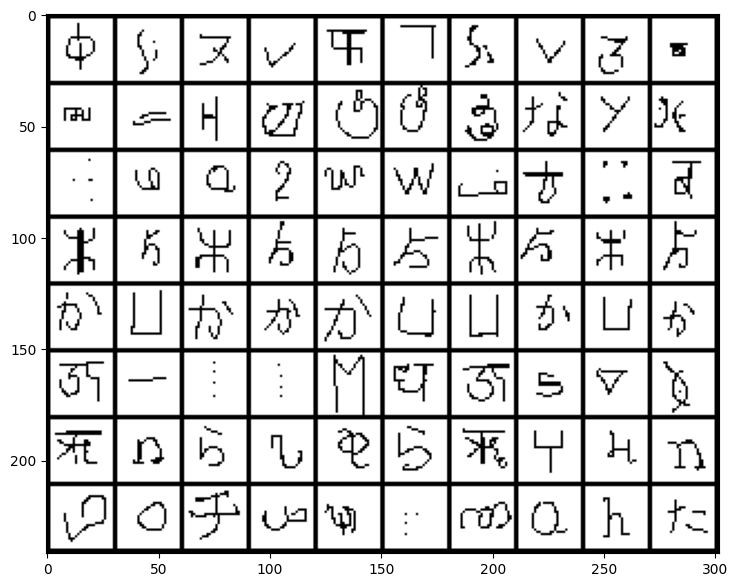

In [143]:
sample_example = extract_sample(8, 5, 5, trainx, trainy)
display_sample(sample_example['images'])

In [144]:
sample_example['images'].shape

torch.Size([8, 10, 3, 28, 28])

In [145]:
base_classes = np.array([label.split('_rot')[0] for label in train_y])
n_unique = len(np.unique(base_classes))
print(f"Available unique classes: {n_unique}")

Available unique classes: 55


## Build model

Модель берет на вход (28x28x3) и возвращает вектор-столбец длиной 64. Каждый модуль модели состоит из свертки 3 × 3 с 64 фильтрами, слоя пакетной нормализации, нелинейности ReLU и слоя максимального объединения 2 × 2 (см. описание задания).

Применительно к изображениям Omniglot 28 × 28 эта архитектура приводит к 64-мерному выходному пространству.

### Задание № 2 - реализуйте энкодер на основе сверточной нейроннй сети

In [146]:
class Image2Vector(nn.Module):
    def __init__(self):
        super(Image2Vector, self).__init__()
        
        self.model = nn.Sequential(
            # Модуль 1: 28x28x3 -> 14x14x64
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Модуль 2: 14x14x64 -> 7x7x64
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Модуль 3: 7x7x64 -> 3x3x64
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Модуль 4: 3x3x64 -> 1x1x64
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Flatten()
        )
    
    def forward(self, x):
        return self.model(x)

In [147]:
# Checking
model = Image2Vector()
dummy_input = torch.randn(5, 3, 28, 28)  # 5 изображений в батче
output = model(dummy_input)
print(output.shape)  

torch.Size([5, 64])


### Задание № 3 - реализуйте Prototypical Networks (``` set_forward_loss ```)

In [148]:
class ProtoNet(nn.Module):
    def __init__(self, encoder):
        """
        Args:
            encoder : CNN encoding the images in sample
            n_way (int): number of classes in a classification task
            n_support (int): number of labeled examples per class in the support set
            n_query (int): number of labeled examples per class in the query set
        """
        super(ProtoNet, self).__init__()
        self.encoder = encoder.cuda()

    def set_forward_loss(self, sample):
        """
        Computes loss, accuracy and output for classification task
        Args:
            sample (torch.Tensor): shape (n_way, n_support+n_query, (dim)) 
        Returns:
            torch.Tensor: shape(2), loss, accuracy and y_hat (predict)
        """
        sample_images = sample['images']
        n_way = sample['n_way']
        n_support = sample['n_support']
        n_query = sample['n_query']
        
        x_support = sample_images[:, :n_support]
        x_query = sample_images[:, n_support:]
        
        x_support = x_support.contiguous().view(n_way * n_support, *x_support.size()[2:])
        x_query = x_query.contiguous().view(n_way * n_query, *x_query.size()[2:])
        
        z_support = self.encoder(x_support)
        z_query = self.encoder(x_query)
        
        z_support = z_support.view(n_way, n_support, -1)
        prototypes = z_support.mean(dim=1)
        
        dists = self.euclidean_dist(z_query, prototypes)

        log_p_y = F.log_softmax(-dists, dim=1)
        y_hat = torch.argmax(log_p_y, dim=1)
        
        y_true = torch.arange(n_way).repeat_interleave(n_query).cuda()
        
        loss_val = F.nll_loss(log_p_y, y_true)
        acc_val = (y_hat == y_true).float().mean()
        
        return loss_val, {
            'loss': loss_val.item(),
            'acc': acc_val.item(),
            'y_hat': y_hat
        }

    @staticmethod
    def euclidean_dist(x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        """
        Computes euclidean distance between x and y
        Args:
            x (Tensor): shape [n, d]
            y (Tensor): shape [m, d]
        Returns:
            Tensor: distance matrix of shape [n, m]
        """
        n = x.size(0)
        m = y.size(0)
        d = x.size(1)
        
        x = x.unsqueeze(1).expand(n, m, d)
        y = y.unsqueeze(0).expand(n, m, d)
        
        return torch.pow(x - y, 2).sum(2)  # [n, m]

In [149]:
def load_protonet_conv(**kwargs):
    """
    Loads the prototypical network model
    Arg:
      x_dim (tuple): dimension of input image
      hid_dim (int): dimension of hidden layers in conv blocks
      z_dim (int): dimension of embedded image
    Returns:
      Model (Class ProtoNet)
    """
    encoder = Image2Vector()

    return ProtoNet(encoder)

## Train

### Задание № 4 - добавьте логирование в процесс обучения (wandb/neptune/tensorboard)

In [150]:
def train(model, optimizer, train_x, train_y, n_way, n_support, n_query, max_epoch, epoch_size):
    """
    Trains the protonet with device-aware tensors
    """
    wandb.init(project="protonet-omniglot", entity="the_nikos-mipt")
    wandb.watch(model)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.5, last_epoch=-1)
    best_acc = 0.0
    
    for epoch in range(max_epoch):
        model.train()
        running_loss = 0.0
        running_acc = 0.0
        
        for episode in tnrange(epoch_size, desc=f"Epoch {epoch+1}"):
            sample = extract_sample(n_way, n_support, n_query, train_x, train_y)
            sample['images'] = sample['images'].to(device)
            
            optimizer.zero_grad()
            loss, output = model.set_forward_loss(sample)
            
            loss.backward()
            optimizer.step()
            
            running_loss += output['loss']
            running_acc += output['acc']
            
            if episode % 10 == 0:
                wandb.log({
                    'batch/loss': output['loss'],
                    'batch/acc': output['acc'],
                    'batch/lr': optimizer.param_groups[0]['lr'],
                    'epoch': epoch
                })
        
        epoch_loss = running_loss / epoch_size
        epoch_acc = running_acc / epoch_size
        
        wandb.log({
            'epoch/loss': epoch_loss,
            'epoch/acc': epoch_acc,
            'epoch/lr': optimizer.param_groups[0]['lr']
        })
        
        print(f'Epoch {epoch+1:02d} | Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.4f}')
        
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            torch.save(model.state_dict(), 'best_model.pth')
            wandb.save('best_model.pth')
        
        scheduler.step()
    
    wandb.finish()

In [151]:
model = load_protonet_conv()

optimizer = optim.Adam(model.parameters(), lr=0.001)

n_way = 55
n_support = 5
n_query = 5

train_x = trainx
train_y = trainy

max_epoch = 5
epoch_size = 2000

In [152]:
%%time

train(model, optimizer, train_x, train_y, n_way, n_support, n_query, max_epoch, epoch_size)

batch/acc,▁▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▅▆▆▆▇▇▇▇▇▇▇▇▇██▇███
batch/loss,██▇▇▇▇▆▆▆▆▆▆▆▆▆▅▅▄▄▃▃▃▃▃▃▃▃▃▃▂▂▃▂▁▁▂▁▁▁▁
batch/lr,███████████████▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▁▁▁▁▁▁▁
epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅███████████
epoch/acc,▁█
epoch/loss,█▁
epoch/lr,█▁
batch/acc,0.84364
batch/loss,0.56736
batch/lr,0.00025
epoch,2


Epoch 1:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 01 | Loss: 2.3021 | Acc: 0.4151


Epoch 2:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 02 | Loss: 1.1692 | Acc: 0.6693


Epoch 3:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 03 | Loss: 0.6824 | Acc: 0.7955


Epoch 4:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 04 | Loss: 0.4654 | Acc: 0.8570


Epoch 5:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 05 | Loss: 0.3632 | Acc: 0.8871


batch/acc,▁▂▂▃▃▃▄▄▃▃▄▅▅▅▅▅▅▅▅▆▇▆▆▆▇▇▇▇▇▇▇█▇▇▇█████
batch/loss,█▇▇▆▆▅▅▄▄▃▃▃▃▃▂▃▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/lr,██████████▄▄▄▄▄▄▄▄▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▁▁▁▁▁▁▃▃▃▃▃▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆█████████
epoch/acc,▁▅▇██
epoch/loss,█▄▂▁▁
epoch/lr,█▄▂▁▁
batch/acc,0.90909
batch/loss,0.32217
batch/lr,6e-05
epoch,4


CPU times: user 28min 18s, sys: 22.7 s, total: 28min 41s
Wall time: 7min 19s


## Test

In [153]:
def test(model, test_x, test_y, n_way, n_support, n_query, test_episode):
    """
    Tests the protonet
    Args:
      model: trained model
      test_x (np.array): images of testing set
      test_y (np.array): labels of testing set
      n_way (int): number of classes in a classification task
      n_support (int): number of labeled examples per class in the support set
      n_query (int): number of labeled examples per class in the query set
      test_episode (int): number of episodes to test on
    """
    running_loss = 0.0
    running_acc = 0.0
    for episode in tnrange(test_episode):
        sample = extract_sample(n_way, n_support, n_query, test_x, test_y)
        sample['images'] = sample['images'].to(device)
        loss, output = model.set_forward_loss(sample)
        running_loss += output['loss']
        running_acc += output['acc']
        
    avg_loss = running_loss / test_episode
    avg_acc = running_acc / test_episode
    print('Test results -- Loss: {:.4f} Acc: {:.4f}'.format(avg_loss, avg_acc))

In [162]:
n_way = 2
n_support = 5
n_query = 5

test_x = testx
test_y = testy

test_episode = 1000

In [163]:
test(model, test_x, test_y, n_way, n_support, n_query, test_episode)

  0%|          | 0/1000 [00:00<?, ?it/s]

Test results -- Loss: 1.7521 Acc: 0.5374


## Test on specific example

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


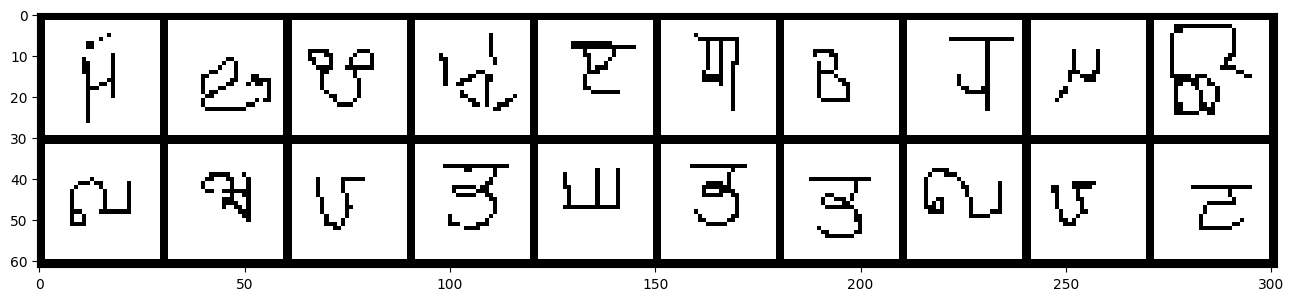

In [164]:
my_sample = extract_sample(n_way, n_support, n_query, test_x, test_y)
display_sample(my_sample['images'])

### Задание № 5 - добавьте функцию для визуализации предсказания с тестирования



In [165]:
def visualize_predictions(model, test_x, test_y, n_way=5, n_support=1, n_query=5, num_visualizations=3):
    """
    Визуализирует предсказания модели на тестовых данных с автоматической настройкой perplexity
    """
    device = next(model.parameters()).device
    model.eval()
    
    for vis_idx in range(num_visualizations):
        sample = extract_sample(n_way, n_support, n_query, test_x, test_y)
        sample['images'] = sample['images'].to(device)
        
        with torch.no_grad():
            _, output = model.set_forward_loss(sample)
            y_hat = output['y_hat']
            
            x_support = sample['images'][:, :n_support]
            x_query = sample['images'][:, n_support:]
            
            x_support = x_support.contiguous().view(n_way * n_support, *x_support.size()[2:])
            x_query = x_query.contiguous().view(n_way * n_query, *x_query.size()[2:])
            
            z_support = model.encoder(x_support)
            z_query = model.encoder(x_query)
            
            embeddings = torch.cat([z_support, z_query], dim=0).cpu().numpy()
            n_samples = embeddings.shape[0]
            
            perplexity = min(30, n_samples - 1)
            
            tsne = TSNE(n_components=2, 
                       perplexity=perplexity,
                       random_state=42,
                       init='pca')
            
            try:
                embeddings_2d = tsne.fit_transform(embeddings)
            except Exception as e:
                print(f"Ошибка t-SNE: {e}")
                continue
                
            plt.figure(figsize=(12, 8))
            
            for i in range(n_way):
                class_points = embeddings_2d[i*n_support:(i+1)*n_support]
                plt.scatter(class_points[:, 0], class_points[:, 1], 
                           label=f'Class {i} Support', s=150, marker='o', alpha=0.7)
            
            for i in range(n_way*n_query):
                point = embeddings_2d[n_way*n_support + i]
                true_class = i // n_query
                pred_class = y_hat[i].item()
                color = 'green' if pred_class == true_class else 'red'
                marker = 'x' if pred_class == true_class else '^'
                plt.scatter(point[0], point[1], color=color, s=100, marker=marker)
            
            plt.title(f"Предсказания модели (Пример {vis_idx+1})\nТочность: {output['acc']:.2f}")
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.tight_layout()
            plt.show()

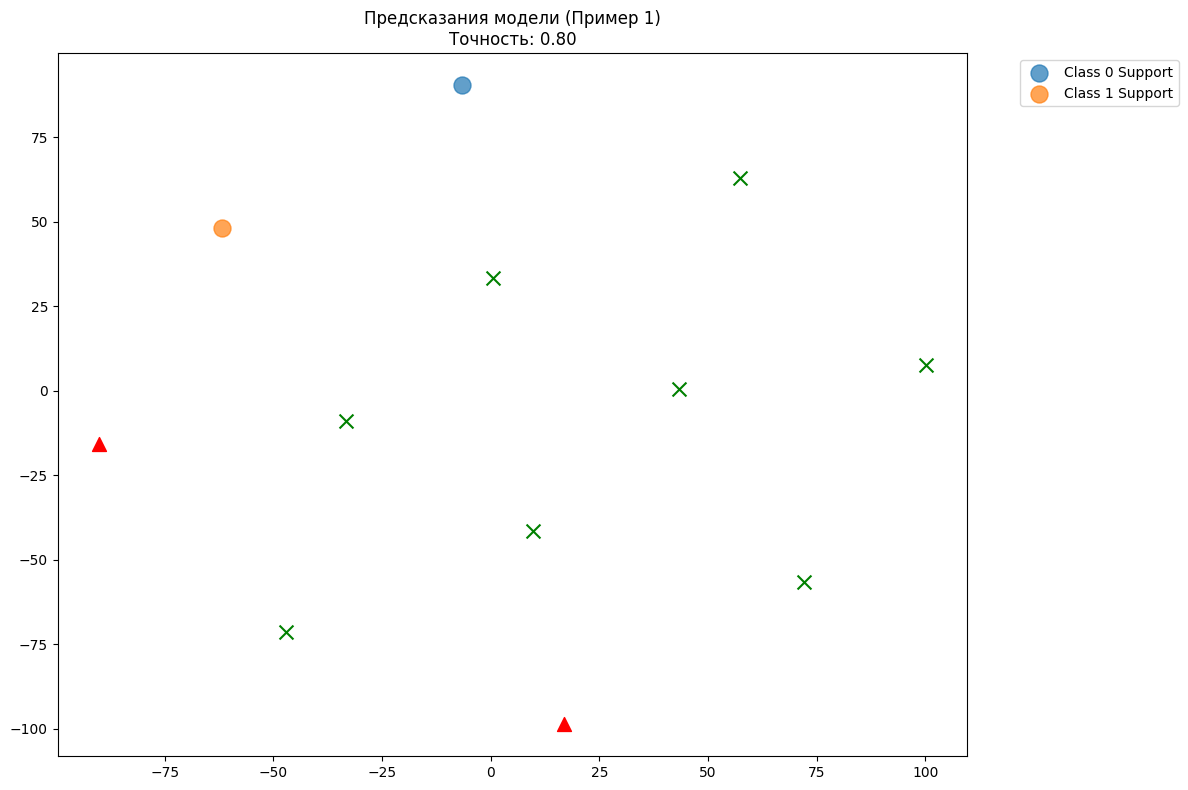

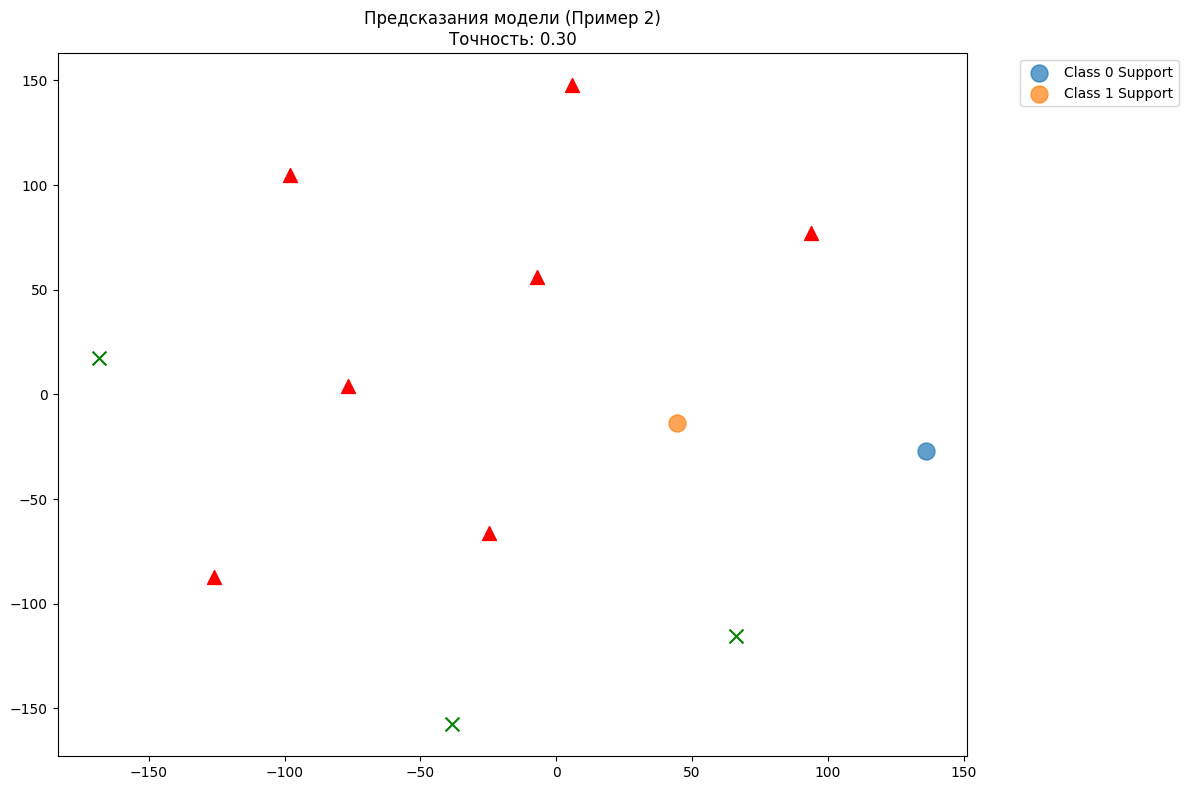

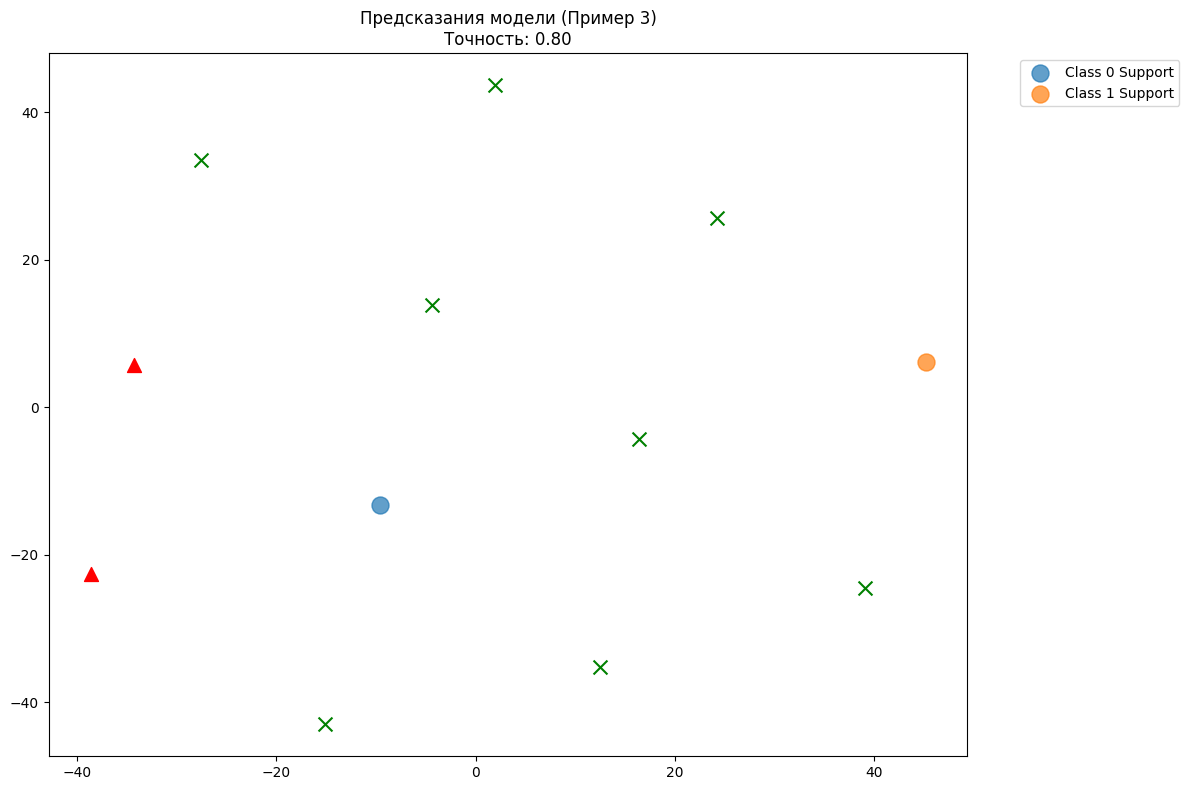

In [167]:
visualize_predictions(
    model=model,
    test_x=testx,
    test_y=testy,
    n_way=2,
    n_support=1,
    n_query=5,
    num_visualizations=3
)

# Задание 6: Downstream task

## Задание 6.1
Ваша задача обучить заданную вами модель CNN методом SimCLR для набора данных CIFAR10, а затем использовать обученный энкодер для решения задачи классификации.

**Примечание:**
- В качестве базового энкодера можете использовать модель из семинара выше (```resnet18```) или определить свою сеть. **Рекомендуется** использовать уже предобученные сети из [torch zoo](https://pytorch.org/vision/stable/models.html).
- В качестве обучающего множества для задачи классификации воспользуйетсь ```X_test```, ```y_test```, которые были определены в самом начале ноутбука. Создайте обучающую и валидационную выборку.
- В новой CNN для задачи классификации требуется обучить только полносвязные слои после энкодера. Для этого вам потребуется "заморозить" веса энкодера и не учить их. Сделать это можно с помощью команды: 
```python
for p in encoder.parameters():
    p.requires_grad = False  
```
- Процесс обучения модели можно взять из предыдущего семинара

## Задание 6.2

Сравните полученный результат обучения c и без использования метода SimCLR.

In [176]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18
from tqdm import tqdm
import numpy as np
from copy import deepcopy

def get_simclr_transform():
    color_jitter = transforms.ColorJitter(0.8, 0.8, 0.8, 0.2)
    transform = transforms.Compose([
        transforms.RandomResizedCrop(32),
        transforms.RandomHorizontalFlip(),
        transforms.RandomApply([color_jitter], p=0.8),
        transforms.RandomGrayscale(p=0.2),
        # Убрали ToTensor, так как данные уже тензоры
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])
    return transform

simclr_transform = get_simclr_transform()


class SimCLRModel(nn.Module):
    def __init__(self, base_encoder):
        super(SimCLRModel, self).__init__()
        self.encoder = base_encoder(pretrained=False)
        self.encoder.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.encoder.maxpool = nn.Identity()
        self.encoder.fc = nn.Identity()
        
        self.projection = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 128)
        )
        
    def forward(self, x):
        h = self.encoder(x)
        z = self.projection(h)
        return h, z

def nt_xent_loss(z1, z2, temperature=0.5):
    batch_size = z1.shape[0]
    
    z = torch.cat([z1, z2], dim=0)
    
    z = nn.functional.normalize(z, dim=1)
    
    sim = torch.matmul(z, z.T) / temperature
    
    mask = torch.eye(2 * batch_size, dtype=torch.bool, device=z.device)
    mask = mask.fill_diagonal_(0)
    
    pos_mask = torch.zeros_like(sim, dtype=torch.bool, device=z.device)
    pos_mask[:batch_size, batch_size:] = torch.eye(batch_size, dtype=torch.bool, device=z.device)
    pos_mask[batch_size:, :batch_size] = torch.eye(batch_size, dtype=torch.bool, device=z.device)
    
    pos_sim = sim[pos_mask].unsqueeze(1)
    neg_sim = sim[mask].reshape(2 * batch_size, -1)
    
    logits = torch.cat([pos_sim, neg_sim], dim=1)
    labels = torch.zeros(2 * batch_size, dtype=torch.long, device=z.device)
    
    loss = nn.CrossEntropyLoss()(logits, labels)
    return loss

def train_simclr(model, train_loader, optimizer, transform, epochs=100):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for (x, _) in tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}'):
            x = x.cuda()
            
            x1 = transform(x)
            x2 = transform(x)
            
            _, z1 = model(x1)
            _, z2 = model(x2)
            
            loss = nt_xent_loss(z1, z2)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        print(f'Epoch {epoch+1}, Loss: {total_loss/len(train_loader)}')
    
    return model


class Classifier(nn.Module):
    def __init__(self, encoder, num_classes=10):
        super(Classifier, self).__init__()
        self.encoder = encoder
        for p in self.encoder.parameters():
            p.requires_grad = False
        self.fc = nn.Linear(512, num_classes)
        
    def forward(self, x):
        h = self.encoder(x)
        return self.fc(h)


def train_classifier(model, train_loader, val_loader, epochs=50):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.fc.parameters(), lr=1e-3)
    best_acc = 0
    best_model = None
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        correct = 0
        total = 0
        
        for (x, y) in tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}'):
            x, y = x.cuda(), y.cuda()
            outputs = model(x)
            loss = criterion(outputs, y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += y.size(0)
            correct += predicted.eq(y).sum().item()
        
        train_acc = 100 * correct / total
        val_acc = evaluate(model, val_loader)
        
        print(f'Epoch {epoch+1}: Train Loss: {train_loss/len(train_loader):.3f}, '
              f'Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%')
        
        if val_acc > best_acc:
            best_acc = val_acc
            best_model = deepcopy(model.state_dict())
    
    model.load_state_dict(best_model)
    return model
    

def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for (x, y) in loader:
            x, y = x.cuda(), y.cuda()
            outputs = model(x)
            _, predicted = outputs.max(1)
            total += y.size(0)
            correct += predicted.eq(y).sum().item()
    return 100 * correct / total



if __name__ == "__main__":

    train_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])
    
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])
    
    train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
    test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
    
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=256, shuffle=False)
    
    print("Training SimCLR...")
    simclr_model = SimCLRModel(resnet18).cuda()
    optimizer = optim.Adam(simclr_model.parameters(), lr=1e-3)
    simclr_model = train_simclr(simclr_model, train_loader, optimizer, simclr_transform, epochs=50)
    
    print("\nTraining classifier with SimCLR features...")
    classifier_simclr = Classifier(simclr_model.encoder).cuda()
    classifier_simclr = train_classifier(classifier_simclr, train_loader, test_loader)
    
    print("\nTraining baseline classifier...")
    encoder = resnet18(pretrained=False)
    encoder.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    encoder.maxpool = nn.Identity()
    encoder.fc = nn.Identity()
    classifier_baseline = Classifier(encoder).cuda()
    classifier_baseline = train_classifier(classifier_baseline, train_loader, test_loader)
    
    simclr_acc = evaluate(classifier_simclr, test_loader)
    baseline_acc = evaluate(classifier_baseline, test_loader)
    
    print(f'\nTest Accuracy with SimCLR: {simclr_acc:.2f}%')
    print(f'Test Accuracy without SimCLR: {baseline_acc:.2f}%')